In [ ]:
%%markdown 
# radio data preprocessing with LibROSA

In [1]:
import pandas as pd
import numpy as np

# import data

known = pd.read_csv('known.csv')    
unknown = pd.read_csv('unknown.csv')
csv_headers = ['Signal type', 'Description', 'Frequency', 'Mode', 'Modulation', 'Bandwidth', 'Location', 'Sample Audio', 'Waterfall image']

In [2]:
import re
import math
# frequencies = csv['Frequency']
# bandwidth = csv['Bandwidth']

def get_array(str, dataset):
    arr = []
    for item in dataset[str]:
        arr.append(item)
    return arr

def get_arr_freq(string, dataset):
    arr = []
    for frq in dataset[string]:
        value = ''
        mult = ''
        if isinstance(frq, str):
            frq = re.sub(r'[^\.\S]', '',frq);
            parsed_char = re.sub(r'\d', '',frq);
            parsed_char = re.sub(r'\W', '',parsed_char);

            parsed_val = re.sub(r'[^\.\d]', ' ',frq);
            # print(parsed_val)
            # parsed_val = re.findall(r'\d+', parsed_val)
            parsed_val = re.split(' ', parsed_val)
            while("" in parsed_val) : 
                parsed_val.remove("") 
            mult = parsed_char
            value = parsed_val
        else:
            # parsed = 0
            value = 0
            mult = 1
            arr.append(value*mult)
            continue
        backup = mult
        if len(value) > 1:
            value = (float(value[0]) + float(value[1])) / 2
        else:
            value = float(value[0])
        if mult[0] == 'M':
            mult = 1000000
        elif mult[0] == 'k':
            mult = 1000
        else: 
            mult = 1
        arr.append(value*mult)
    return arr

# for header in csv_headers:
#     data[header] = []
data = {}
for header in csv_headers:
    data_name = header.replace(' ', '_')
    if header != 'Frequency' and header != 'Bandwidth':
        data[data_name] = get_array(header, known)
        data[data_name] += get_array(header, unknown)
    else:
        data[data_name] = get_arr_freq(header, known)
        data[data_name] += get_arr_freq(header, unknown)


In [ ]:
%%markdown
# analyse data with LibROSA

In [3]:
from tqdm import tqdm
from librosa import display
import librosa
import math
import libs
import libs.fingerprint as fingerprint
from libs.file_reader import FileReader

from termcolor import colored
audio_paths = data['Sample_Audio']

In [4]:
audio_paths = data['Sample_Audio']
data['fingerprints'] = []
index = 0
for filename in audio_paths:
# for i in range(301):
    # filename = audio_paths[i]
    reader = FileReader(filename)
    audio = reader.parse_audio()


    for channeln, channel in enumerate(audio['channels']):
        f_p = fingerprint.fingerprint(channel, Fs=audio['Fs'])
    data['fingerprints'].append(f_p)    
    # msg = ' * %s %s: %s' % (
    #     colored('id=%s', 'white', attrs=['dark']),       # id
    #     colored('channels=%d', 'white', attrs=['dark']), # channels
    #     colored('%s', 'white', attrs=['bold'])           # filename
    #   )
    # print (msg % (index, len(audio['channels']), filename))
    # if i % 10 == 0:
    # print(index)
    index += 1

In [12]:
print(len(data['fingerprints']))

import pickle

namespace = 'signal_fingerprints'

with open(namespace + '_data.p', 'wb') as _file:
    pickle.dump(data, _file)

602


In [5]:
import numpy as np
import pickle
namespace = 'signal_fingerprints'
data = pickle.load(open(namespace + '_data.p', 'rb'))


In [8]:

# add SOMpy library and tun it
from operator import itemgetter

import sompylib3.sompy as SOM
from sompylib3.sompy import denormalize_by

# get max length
max_length = 0
for fp in data['fingerprints']:
    if len(fp[0]) > max_length:
        max_length = len(fp[0])

print(max_length)

# concatenate the audio features
data_features = []
for dp in data['fingerprints']:
    freq = np.array(dp[0])
    time = np.array(dp[1])

    freq = np.resize(freq, max_length)
    time = np.resize(time, max_length)

    # data_features.append([freq, time])
    data_features.append(freq)
data_features = np.array(data_features)

print((data_features).shape)
# print(data_features[0])
# features_shape = (data_features.shape[1], data_features.shape[2])
# concatenated_features = data_features.reshape(602 * features_shape[0], features_shape[1])
# print(concatenated_features.shape)

map_size = [25, 25]

sm = SOM.SOM('', data_features, mapsize = map_size, norm_method = 'var', initmethod='pca')
sm.init_map()
sm.train(trainlen=None, n_job = 1, shared_memory = 'no', verbose='on')


4776
(602, 4776)

initialization method = pca, initializing..

initialization done in 0.170000 seconds

rough training...
radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 32

epoch: 1 ---> elapsed time:  0.206000, quantization error: 64.102878 

epoch: 2 ---> elapsed time:  0.177000, quantization error: 60.080904 

epoch: 3 ---> elapsed time:  0.191000, quantization error: 44.653845 

epoch: 4 ---> elapsed time:  0.157000, quantization error: 42.345368 

epoch: 5 ---> elapsed time:  0.146000, quantization error: 41.846092 

epoch: 6 ---> elapsed time:  0.194000, quantization error: 41.630147 

epoch: 7 ---> elapsed time:  0.165000, quantization error: 41.470141 

epoch: 8 ---> elapsed time:  0.139000, quantization error: 41.345882 

epoch: 9 ---> elapsed time:  0.156000, quantization error: 41.218695 

epoch: 10 ---> elapsed time:  0.149000, quantization error: 41.079847 

epoch: 11 ---> elapsed time:  0.164000, quantization error: 40.942514 

epoch: 12 ---> elapsed time:  0.15

clustering based on default parameters...


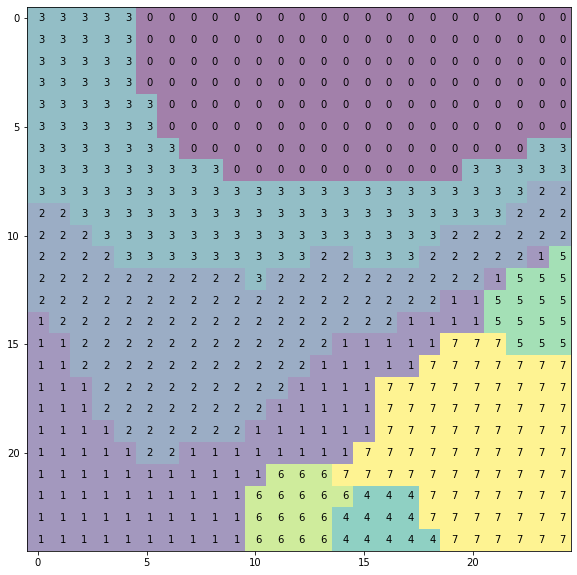

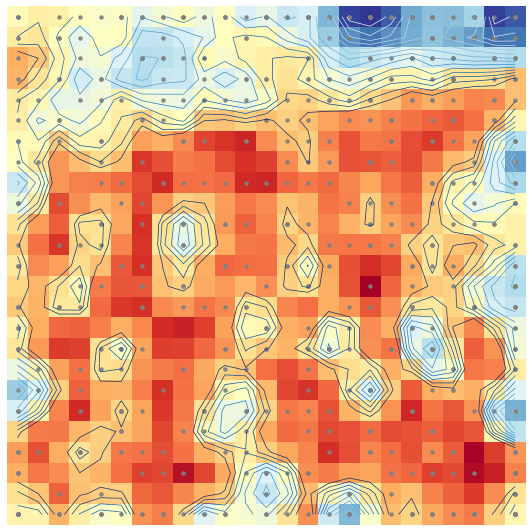

In [9]:
view2D  = sm.hit_map_cluster_number()
view2D  = sm.view_U_matrix()

In [10]:
data['bmus'] = []
# print(np.asarray(data['fingerprints'][0]).shape)
for i in tqdm(range(len(data_features))):
    feature = data_features[i]
    # feature = np.asarray(feature)
    # print(feature.shape)
    # bmu = sm.project_data(np.asarray(feature).reshape(features_shape[0] * features_shape[1], -1))
    bmu = sm.project_data(np.asarray(feature).reshape(1, -1))

    # print(feature.shape)
    data['bmus'].append(bmu.tolist())

0%|          | 2/602 [00:00<01:14,  8.08it/s](4776,)
(4776,)
  1%|          | 5/602 [00:00<01:06,  8.92it/s](4776,)
(4776,)
(4776,)
  1%|          | 7/602 [00:00<01:06,  8.99it/s](4776,)
(4776,)
  1%|▏         | 9/602 [00:00<01:06,  8.96it/s](4776,)
(4776,)
  2%|▏         | 11/602 [00:01<01:06,  8.94it/s](4776,)
(4776,)
  2%|▏         | 13/602 [00:01<01:04,  9.08it/s](4776,)
(4776,)
  2%|▏         | 15/602 [00:01<01:05,  9.00it/s](4776,)
(4776,)
  3%|▎         | 17/602 [00:01<01:05,  8.96it/s](4776,)
(4776,)
  3%|▎         | 19/602 [00:02<01:05,  8.93it/s](4776,)
(4776,)
  3%|▎         | 21/602 [00:02<01:04,  9.04it/s](4776,)
(4776,)
  4%|▍         | 23/602 [00:02<01:04,  9.02it/s](4776,)
(4776,)
  4%|▍         | 25/602 [00:02<01:05,  8.86it/s](4776,)
(4776,)
  4%|▍         | 27/602 [00:02<01:03,  9.06it/s](4776,)
(4776,)
  5%|▍         | 29/602 [00:03<01:03,  9.06it/s](4776,)
(4776,)
  5%|▌         | 31/602 [00:03<01:03,  8.99it/s](4776,)
(4776,)
  5%|▌         | 33/602 [00:03<01:02, 

In [17]:
print(data['bmus'][1])

[925]


In [11]:
cb = sm.codebook[:]
codebook = {
    'data': cb.tolist(),
    'size': map_size
}
with open(namespace + '_codebook.p', 'wb') as _file:
    pickle.dump(codebook, _file)